In [37]:
!ls -al ../input/mydata/

total 148
drwxr-xr-x 2 nobody nogroup     0 Feb 24 19:58 .
drwxr-xr-x 3 root   root     4096 Feb 26 00:55 ..
-rw-r--r-- 1 nobody nogroup 69483 Feb 24 19:58 EgTemp1.csv
-rw-r--r-- 1 nobody nogroup 76423 Feb 24 19:58 canTemp.csv


In [38]:
# Detect hardware, return appropriate distribution strategy
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = False

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)
print(tpu)

REPLICAS:  1
False


In [39]:
import pandas as pd
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [40]:
# Global Data 
startDate='1950-1-1'
endDate=  '2014-1-1'

#fileName='EgTemp1.csv' ; Tit='Egypt'; Cols=['dt','AverageTemperature']
fileName='canTemp.csv' ; Tit='Canada';Cols=['Dt','Tmp']

#tpu=False
# Load
df= pd.read_csv('../input/mydata/'+fileName)
print(df.columns)
print(df.shape)
df.head()
df.columns

Index(['Dt', 'Tmp', 'tol', 'City', 'Country'], dtype='object')
(1365, 5)


Index(['Dt', 'Tmp', 'tol', 'City', 'Country'], dtype='object')

In [41]:
print(df.describe())
print(df.shape)
data=df.copy()
if len(data[data.isna().any(axis=1)])!=0:
    print('--->>Drop Nans')
    print(data[data.isna().any(axis=1)])
data=data.dropna()


data[Cols[0]] = pd.to_datetime(data[Cols[0]])
mask = (data[Cols[0]] >= startDate) & (data[Cols[0]] <= endDate)
data=data.loc[mask]
data = pd.DataFrame(list(data[Cols[1]]), index=data[Cols[0]],columns=['temp'])
print(data.describe())
data

               Tmp          tol
count  1365.000000  1365.000000
mean     -1.333622     0.534285
std      10.471839     0.320671
min     -22.930000     0.160000
25%     -11.017000     0.320000
50%      -0.280000     0.424000
75%       8.235000     0.658000
max      15.211000     2.760000
(1365, 5)
             temp
count  765.000000
mean    -1.044107
std     10.344234
min    -22.930000
25%    -10.548000
50%     -0.280000
75%      8.377000
max     15.211000


,temp
Dt,
1950-01-01,-20.389
1950-02-01,-19.863
1950-03-01,-10.947
1950-04-01,-3.218
1950-05-01,3.827
...,...
2013-05-01,3.880
2013-06-01,8.366
2013-07-01,14.101


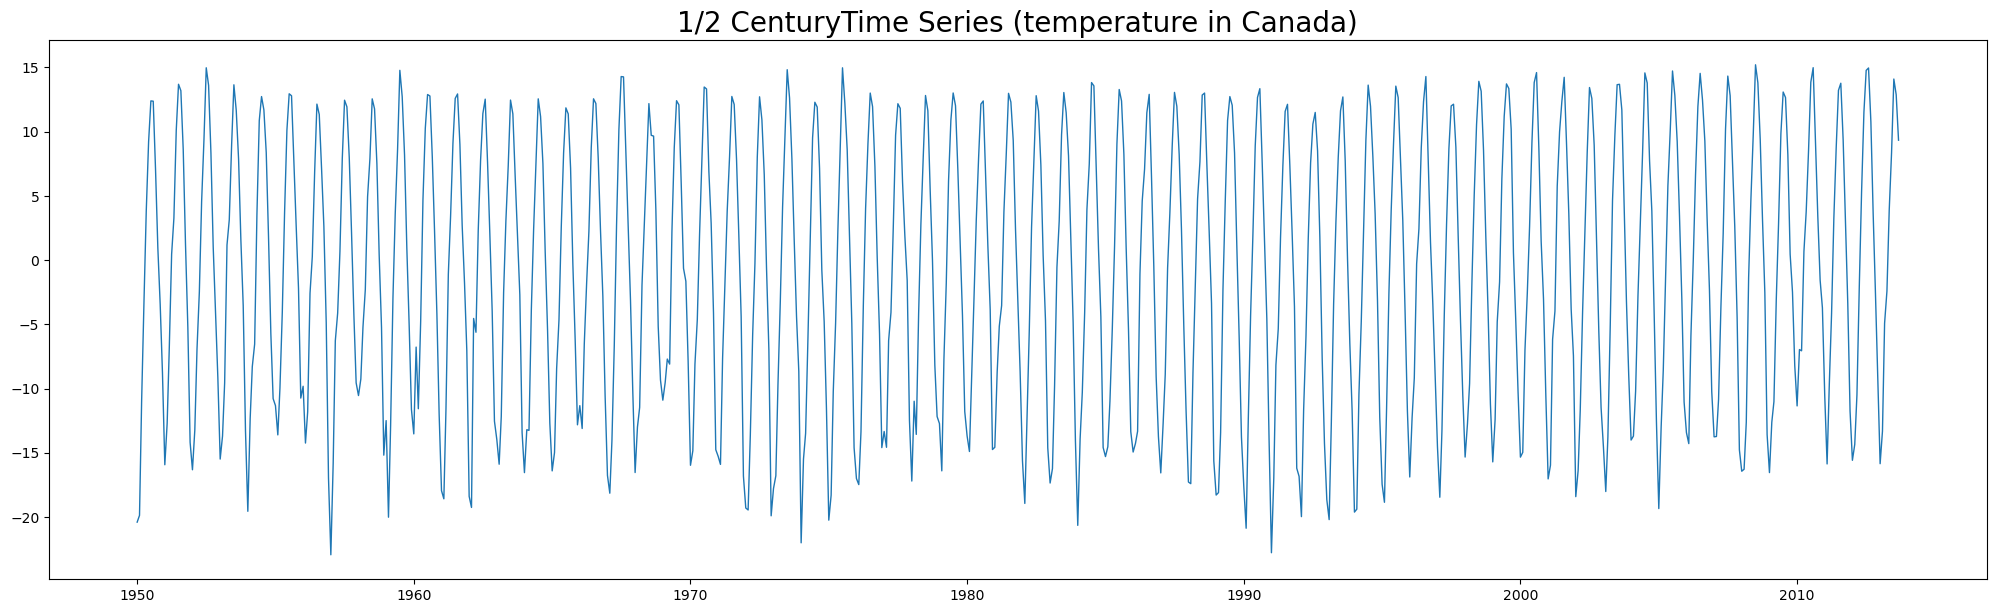

In [42]:
plt.figure(figsize=(25, 7))
plt.plot(data, linewidth=1)
# plt.grid()
plt.title("1/2 CenturyTime Series (temperature in {})".format(Tit),fontsize=20)
plt.show()

# Scale / resumeScace

In [43]:
def resScale(df,tMin,tMax):
    d=df * (tMax-tMin)+tMin
    return d
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
tMin,tMean,tMax=(data['temp'].min(),data['temp'].mean(),data['temp'].max())
print('Min Mean Max',tMin,tMean,tMax)
data_scaled = scaler.fit_transform(data)
#d=resScale(data_scaled,tMin,tMax)
#d

Min Mean Max -22.93 -1.0441071895424836 15.211


In [44]:
steps= 120 #Input Blocks
inp = []
out = []
for i in range(len(data_scaled) - (steps)):
    inp.append(data_scaled[i:i+steps])
    out.append(data_scaled[i+steps])
inp= np.asanyarray(inp)
out= np.asanyarray(out)
trainRatio=0.80
trainSize=int(trainRatio*len(data))
x_train = inp[:trainSize,:,:]
x_test = inp[trainSize:,:,:]    
y_train = out[:trainSize]    
y_test= out[trainSize:]
print('I/O',inp.shape,out.shape)
print('Train/test',x_train.shape,x_test.shape)

I/O (645, 120, 1) (645, 1)
Train/test (612, 120, 1) (33, 120, 1)


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

In [46]:
if tpu:
    import tensorflow as tf
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

    # instantiate a distribution strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():
        model = Sequential()
        model.add(LSTM(50, return_sequences= True, input_shape= (steps,1)))
        model.add(LSTM(50, return_sequences=True))
        model.add(LSTM(50))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = 'adam')
else:
    model = Sequential()
    model.add(LSTM(50, return_sequences= True, input_shape= (steps,1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [47]:
import time
start = time.time()
model.fit(x_train,y_train,epochs=100, verbose=1, )
end = time.time()
print(end - start)

Epoch 1/100
20/20 [==============================] - 6s 22ms/step - loss: 0.1142
Epoch 2/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0788
Epoch 3/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0736
Epoch 4/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0705
Epoch 5/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0634
Epoch 6/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0344
Epoch 7/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0104
Epoch 8/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0062
Epoch 9/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0056
Epoch 10/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0050
Epoch 11/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0045
Epoch 12/100
20/20 [==============================] - 0s 22ms/step - loss: 0.0046
Epoch 13/100
20/20 [=====

In [48]:
x_test

array([[[0.15484649],
        [0.18284785],
        [0.43965811],
        ...,
        [0.6916966 ],
        [0.56044676],
        [0.50394589]],

       [[0.18284785],
        [0.43965811],
        [0.49749613],
        ...,
        [0.56044676],
        [0.50394589],
        [0.32382476]],

       [[0.43965811],
        [0.49749613],
        [0.75213025],
        ...,
        [0.50394589],
        [0.32382476],
        [0.18536483]],

       ...,

       [[0.95936132],
        [0.96014787],
        [0.90786817],
        ...,
        [0.53821347],
        [0.70291812],
        [0.82053433]],

       [[0.96014787],
        [0.90786817],
        [0.71463779],
        ...,
        [0.70291812],
        [0.82053433],
        [0.97089746]],

       [[0.90786817],
        [0.71463779],
        [0.51653077],
        ...,
        [0.82053433],
        [0.97089746],
        [0.93909441]]])

In [49]:
print("Predicted Value",model.predict(x_train)[4][0])
print("Expected value",y_train[4][0])
predictions=model.predict(x_test)
#print(predictions[:5])
pred_df=pd.DataFrame(predictions,columns=['Pred'])
#print(pred_df[:5])
pred_df['TrueValues']=y_test
print(pred_df[:5])

20/20 [==============================] - 1s 7ms/step
Predicted Value 0.65620726
Expected value 0.7239977976455783
2/2 [==============================] - 0s 8ms/step
       Pred  TrueValues
0  0.251712    0.323825
1  0.237380    0.185365
2  0.332918    0.342571
3  0.480240    0.491964
4  0.632299    0.686348


Text(0.5, 1.0, 'Predictions VS True Values on Scaled Testing Set Canada')

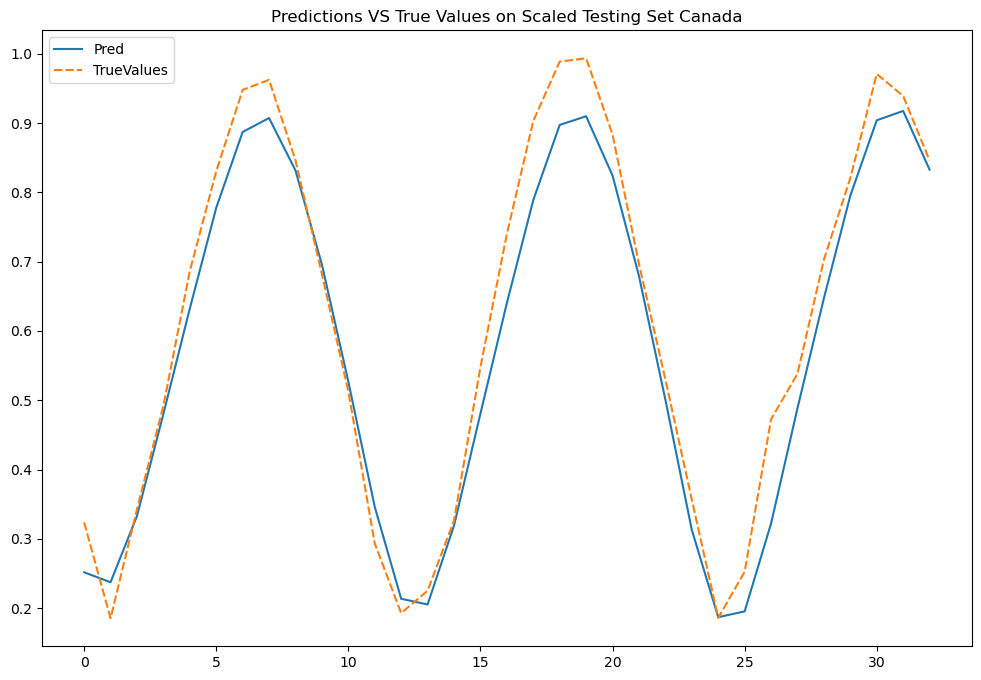

In [50]:
plt.figure(figsize=(12,8))
sns.lineplot(data= pred_df)
plt.title("Predictions VS True Values on Scaled Testing Set {}".format(Tit))

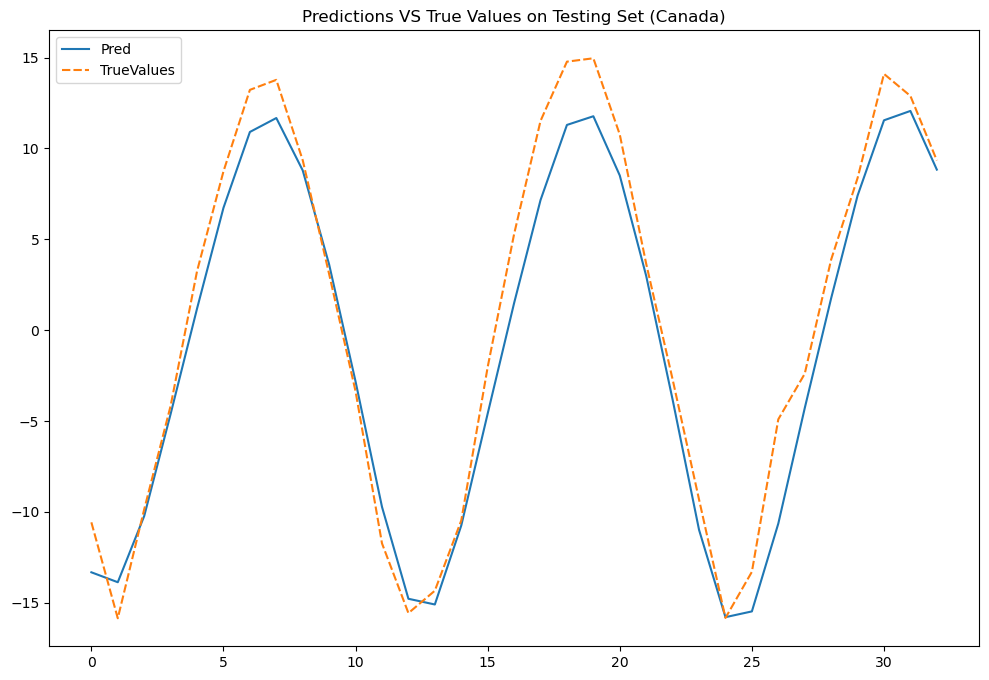

In [51]:
predDfResScale=pred_df.copy()
predDfResScale['Pred']=resScale(pred_df['Pred'],tMin,tMax)
predDfResScale['TrueValues']=resScale(y_test,tMin,tMax)
plt.figure(figsize=(12,8))
sns.lineplot(data= predDfResScale)
plt.title("Predictions VS True Values on Testing Set ({})".format(Tit))
plt.show()

In [52]:
#print(x_test.shape)
#xx=x_test[-1]
#print(xx.shape)
#xx=np.reshape(xx, (1,24,1))
#p=model.predict(xx)

# Generate N

In [53]:
N=12*10 # more 10 years
from datetime import timedelta
def generateOne(model,list_24):
    inp=np.reshape(list_24, (1,steps,1))
    p=model.predict(inp,verbose=False)
    list_24.append(np.array(p[0]))
    list_24=list_24[1:]
    return p,list_24
def generateN(model,list_24,N):
    out=[]
    for i in range(N):
        p,list_24=generateOne(model,list_24)
        out.append(p)
    return out
    
l_24=list(x_test[-1])
yNew=generateN(model,l_24,N)

ddd=data.copy()
last_date = ddd.iloc[[-1]].index
for i in range(N):
    last_date=last_date+ timedelta(days=30)
    ddd = ddd.append(pd.DataFrame(index=last_date))
    ddd['temp'][-1]=resScale(yNew[i],tMin,tMax)
    #print(yNew[i],resScale(yNew[i],tMin,tMax))

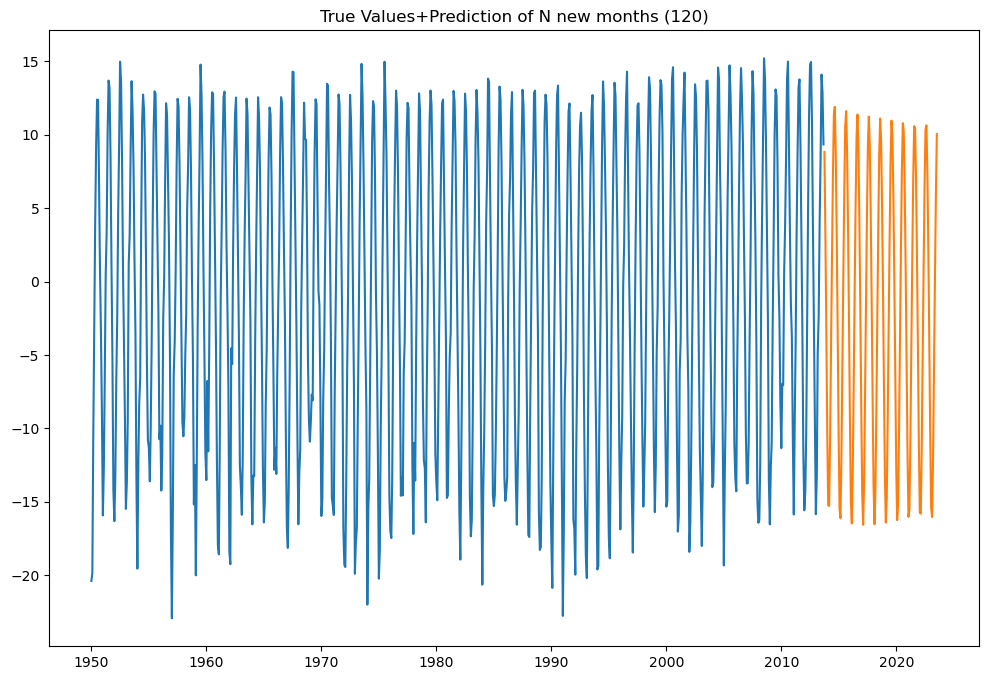

In [54]:
plt.figure(figsize=(12,8))
recs=ddd.shape[0]
#
plt.plot(ddd.index[0:recs-N],ddd['temp'][0:recs-N])
plt.plot(ddd.index[recs-N:],ddd['temp'][recs-N:])
plt.title("True Values+Prediction of N new months ({})".format(N,Tit))
#data.shape
plt.show()